In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('churn.csv')
 
df.columns = df.columns.str.lower().str.replace(' ', '_')
 
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
 
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
 
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)
 
df.churn = (df.churn == 'yes').astype(int)

In [3]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
 
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values
 
del df_train['churn']
del df_val['churn']
del df_test['churn'] 

In [4]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
 
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [5]:
dv = DictVectorizer(sparse=False)
 
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [6]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
 
y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8055358410220014

In [9]:
print(len(y_val))
print((y_val == churn_decision).sum())
print((y_val == churn_decision).sum() / len(y_val))
print((y_val == churn_decision).mean())

1409
1135
0.8055358410220014
0.8055358410220014


In [11]:
thresholds = np.linspace(0, 1, 21)
print(thresholds)

scores = []
 
for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
0.00 0.274
0.05 0.508
0.10 0.605
0.15 0.664
0.20 0.705
0.25 0.738
0.30 0.759
0.35 0.767
0.40 0.781
0.45 0.793
0.50 0.806
0.55 0.804
0.60 0.800
0.65 0.787
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


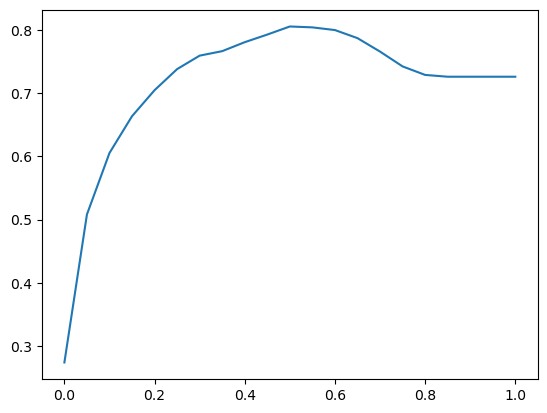

In [12]:
plt.plot(thresholds,scores)

In [13]:
from sklearn.metrics import accuracy_score
 
thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.508
0.10 0.605
0.15 0.664
0.20 0.705
0.25 0.738
0.30 0.759
0.35 0.767
0.40 0.781
0.45 0.793
0.50 0.806
0.55 0.804
0.60 0.800
0.65 0.787
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [15]:
# people who are going to churn
actual_positive = (y_val == 1)
# people who are not going to churn
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [17]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

print('tp: ', tp)
print('tn: ', tn)
print('fp: ', fp)
print('fn: ', fn)

tp:  212
tn:  923
fp:  100
fn:  174


In [18]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[923, 100],
       [174, 212]])

In [19]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.66, 0.07],
       [0.12, 0.15]])

In [21]:
accuracy = (tp +  tn) / (tp + tn + fp + fn)
print(accuracy)

precision = tp / (tp + fp)
print(precision)

recall = tp / (tp + fn)
print(recall)

0.8055358410220014
0.6794871794871795
0.5492227979274611


In [22]:
tpr = tp / (tp + fn)
print(tpr)
fpr = fp / (fp + tn)
print(fpr)

0.5492227979274611
0.09775171065493646


In [23]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
 
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
 
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
 
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
 
    scores.append((t, tp, tn, fp, fn))
 
scores

[(0.0, 386, 0, 1023, 0),
 (0.01, 385, 122, 901, 1),
 (0.02, 383, 215, 808, 3),
 (0.03, 382, 270, 753, 4),
 (0.04, 382, 309, 714, 4),
 (0.05, 379, 337, 686, 7),
 (0.06, 377, 367, 656, 9),
 (0.07, 375, 394, 629, 11),
 (0.08, 370, 427, 596, 16),
 (0.09, 370, 457, 566, 16),
 (0.1, 367, 486, 537, 19),
 (0.11, 364, 505, 518, 22),
 (0.12, 363, 527, 496, 23),
 (0.13, 361, 537, 486, 25),
 (0.14, 358, 562, 461, 28),
 (0.15, 353, 582, 441, 33),
 (0.16, 349, 594, 429, 37),
 (0.17, 347, 612, 411, 39),
 (0.18, 347, 625, 398, 39),
 (0.19, 342, 643, 380, 44),
 (0.2, 337, 656, 367, 49),
 (0.21, 332, 672, 351, 54),
 (0.22, 328, 686, 337, 58),
 (0.23, 322, 707, 316, 64),
 (0.24, 319, 716, 307, 67),
 (0.25, 314, 726, 297, 72),
 (0.26, 312, 736, 287, 74),
 (0.27, 310, 749, 274, 76),
 (0.28, 302, 762, 261, 84),
 (0.29, 299, 766, 257, 87),
 (0.3, 292, 778, 245, 94),
 (0.31, 289, 786, 237, 97),
 (0.32, 282, 788, 235, 104),
 (0.33, 279, 794, 229, 107),
 (0.34, 273, 803, 220, 113),
 (0.35000000000000003, 271, 8

In [24]:
columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,tp,tn,fp,fn
0,0.00,386,0,1023,0
1,0.01,385,122,901,1
2,0.02,383,215,808,3
3,0.03,382,270,753,4
4,0.04,382,309,714,4
...,...,...,...,...,...
96,0.96,0,1023,0,386
97,0.97,0,1023,0,386
98,0.98,0,1023,0,386
99,0.99,0,1023,0,386


In [25]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,367,486,537,19,0.950777,0.524927
20,0.2,337,656,367,49,0.873057,0.358749
30,0.3,292,778,245,94,0.756477,0.239492
40,0.4,252,848,175,134,0.652850,0.171065
50,0.5,212,923,100,174,0.549223,0.097752
60,0.6,155,972,51,231,0.401554,0.049853
70,0.7,69,1010,13,317,0.178756,0.012708
80,0.8,4,1023,0,382,0.010363,0.000000
90,0.9,0,1023,0,386,0.000000,0.000000


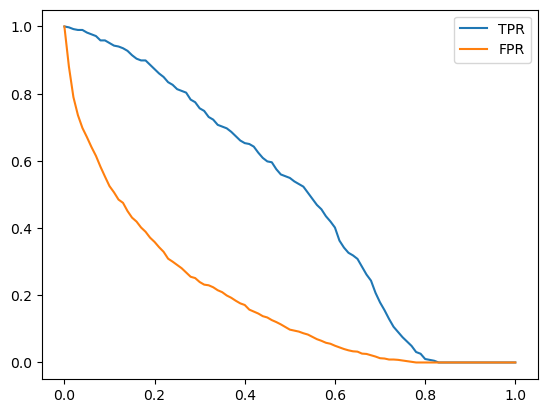

In [26]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

In [27]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)
# Output: array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

# Accuracy for our random model is around 50%
((y_rand >= 0.5) == y_val).mean()
 
# Output: 0.5017743080198722

0.5017743080198722

In [28]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
 
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
 
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
 
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
 
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
 
        scores.append((t, tp, tn, fp, fn))
 
    columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
    df_scores = pd.DataFrame(scores, columns=columns)
 
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
 
    return df_scores

In [29]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,347,100,923,39,0.898964,0.902248
20,0.2,307,201,822,79,0.795337,0.803519
30,0.3,276,299,724,110,0.715026,0.707722
40,0.4,237,399,624,149,0.613990,0.609971
50,0.5,202,505,518,184,0.523316,0.506354
60,0.6,161,614,409,225,0.417098,0.399804
70,0.7,121,721,302,265,0.313472,0.295210
80,0.8,78,817,206,308,0.202073,0.201369
90,0.9,40,922,101,346,0.103627,0.098729


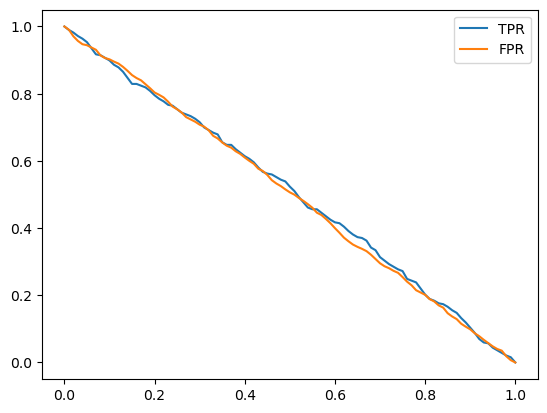

In [30]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

In [31]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [33]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
print(y_ideal)

y_ideal_pred = np.linspace(0, 1, len(y_ideal))
print(y_ideal_pred)

[0 0 0 ... 1 1 1]
[0.00000000e+00 7.10227273e-04 1.42045455e-03 ... 9.98579545e-01
 9.99289773e-01 1.00000000e+00]


In [34]:
1 - y_val.mean()

0.7260468417317246

In [35]:
accuracy_ideal = ((y_ideal_pred >= 0.726) == y_ideal).mean()
accuracy_ideal

1.0

In [36]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,386,141,882,0,1.000000,0.862170
20,0.2,386,282,741,0,1.000000,0.724340
30,0.3,386,423,600,0,1.000000,0.586510
40,0.4,386,564,459,0,1.000000,0.448680
50,0.5,386,704,319,0,1.000000,0.311828
60,0.6,386,845,178,0,1.000000,0.173998
70,0.7,386,986,37,0,1.000000,0.036168
80,0.8,282,1023,0,104,0.730570,0.000000
90,0.9,141,1023,0,245,0.365285,0.000000


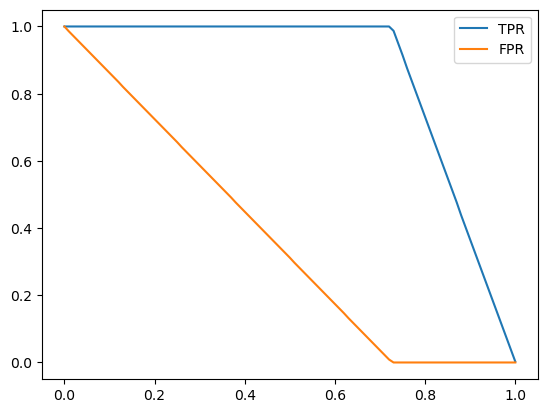

In [37]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

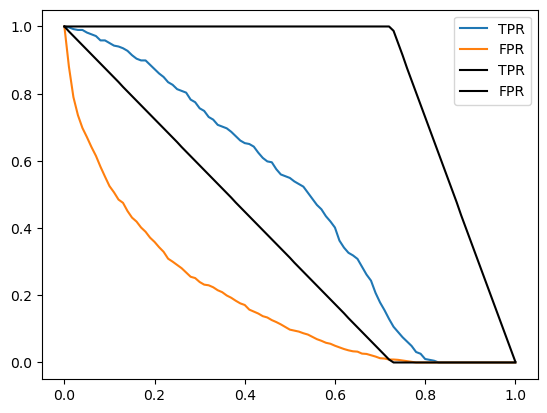

In [38]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
 
#plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
#plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
 
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR', color = 'black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR', color = 'black')
 
plt.legend()

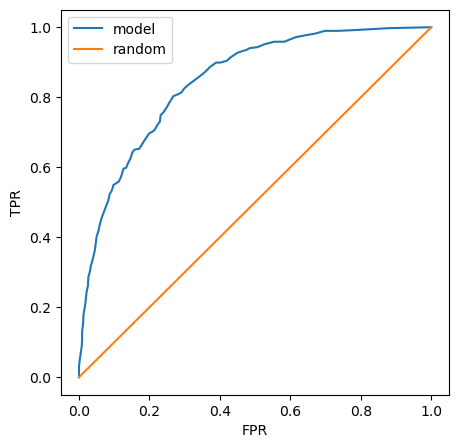

In [39]:
plt.figure(figsize=(5,5))
 
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
 
plt.xlabel('FPR')
plt.ylabel('TPR')
 
plt.legend()

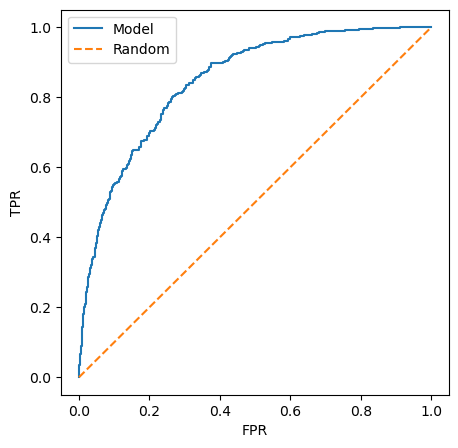

In [40]:
# We can also use the ROC functionality of scikit learn package
from sklearn.metrics import roc_curve
 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
 
plt.figure(figsize=(5,5))
 
plt.plot(fpr, tpr, label='Model')
plt.plot([0,1], [0,1], label='Random', linestyle='--')
 
plt.xlabel('FPR')
plt.ylabel('TPR')
 
plt.legend()

In [41]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.8465956573929162

In [42]:
auc(df_scores.fpr, df_scores.tpr)

0.8463208889834327

In [43]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [44]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8465956573929162

In [45]:
from sklearn.metrics import roc_auc_score
 
roc_auc_score(y_val, y_pred)

0.8465956573929162

In [52]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
 
    return dv, model

In [53]:
dv, model = train(df_train, y_train)

In [54]:
def predict(df, dv, model):
     dicts = df[categorical + numerical].to_dict(orient='records')
 
     X = dv.fit_transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
 
     return y_pred

In [55]:
y_pred = predict(df_val, dv, model)
y_pred

array([0.0073589 , 0.2097195 , 0.22070641, ..., 0.14887918, 0.7848383 ,
       0.81057977])

In [57]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.churn.values
    y_val = df_val.churn.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
 
scores

[0.8493392490816277,
 0.8420018564356436,
 0.8590269587894291,
 0.8330260883877869,
 0.8242555831265509,
 0.840959040959041,
 0.8437154021491371,
 0.8223513598987982,
 0.8450570623981029,
 0.8611811367685119]

In [58]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.842 +- 0.012


In [74]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
 
    return dv, model

In [75]:
dv, model = train(df_train, y_train, C=0.001)

In [76]:
from sklearn.model_selection import KFold
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
 
for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
     
    scores = []
 
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
 
        y_train = df_train.churn.values
        y_val = df_val.churn.values
 
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.001 0.826 +- 0.016
C=0.01 0.840 +- 0.012
C=0.1 0.842 +- 0.012
C=0.5 0.842 +- 0.012
C=1 0.842 +- 0.012
C=5 0.842 +- 0.012
C=10 0.842 +- 0.012


In [77]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)
 
auc = roc_auc_score(y_test, y_pred)
auc

0.8579400803839363